# RipsNet - tutorial

### import

In [20]:
import os
# import keras
os.environ["TF_USE_LEGACY_KERAS"] = "1" # need this to use ragged=True in the input.

# packages import 

import gudhi as gd
import numpy as np
from tqdm import tqdm 
import tensorflow as tf
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from gudhi.representations import DiagramSelector
from gudhi.representations import Landscape, PersistenceImage

from src.dataset import create_multiple_circles
from src.utils import DenseRagged, PermopRagged

## ripsnet

In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [21]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

Next we use helper functions to compute these point clouds.

In [22]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 100/100 [00:00<00:00, 119.65it/s]


Let's check some of these point clouds!

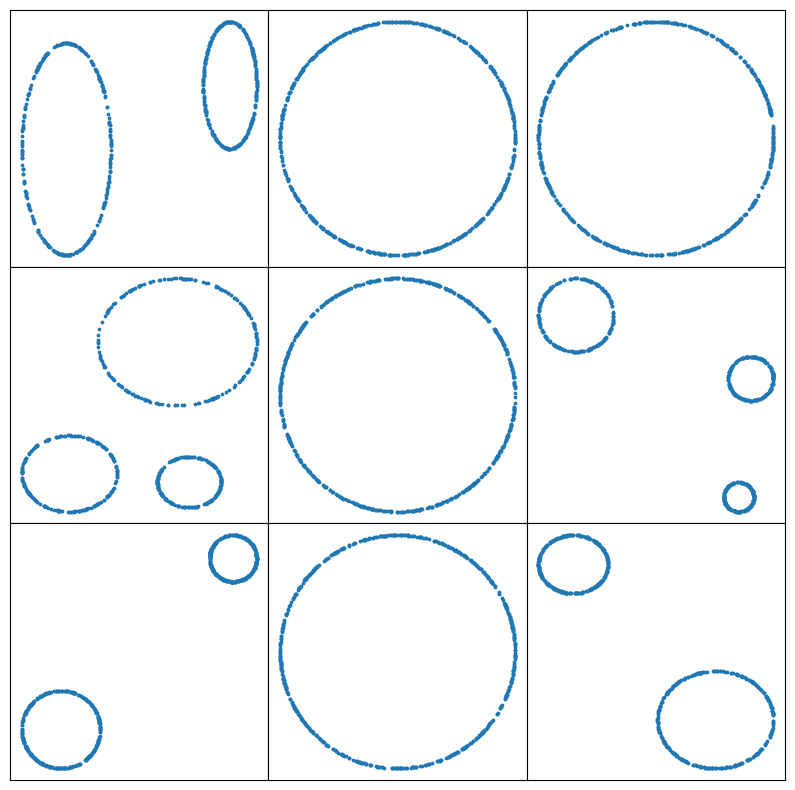

In [23]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

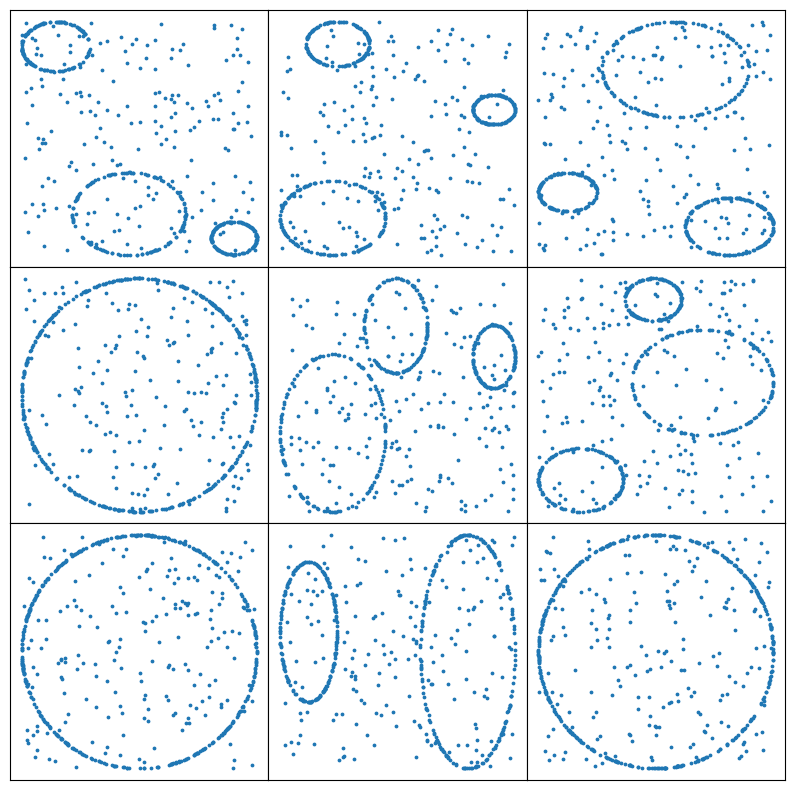

In [24]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [25]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

In order to train RipsNet, we need the correct topology on the train data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [26]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [27]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

100%|██████████| 900/900 [00:12<00:00, 74.53it/s]


In [28]:
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

100%|██████████| 300/300 [00:04<00:00, 73.89it/s]


In [29]:
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:02<00:00, 127.85it/s]


RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [30]:
PVs_train, clean_PVs_test, noisy_PVs_test, PVs_params = [], [], [], []
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates). 

In [31]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

We can now compute and normalize the vectorizations (this can help RipsNet training)!

In [32]:
PI_params = {'bandwidth': sigma, 
             'weight': lambda x: 10*np.tanh(x[1]), 
             'resolution': [50,50], 
             'im_range': im_bnds
             }
PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
noisy_PI_test = PersistenceImage(**PI_params).fit_transform(noisy_pds_test)
MPI = np.max(PI_train)
PI_train /= MPI
clean_PI_test /= MPI
noisy_PI_test /= MPI

In [33]:
PL_params = {'num_landscapes': 5, 'resolution': 300, 'sample_range': sp_bnds}
PL_train = Landscape(**PL_params).fit_transform(pds_train)
clean_PL_test = Landscape(**PL_params).fit_transform(clean_pds_test)
noisy_PL_test = Landscape(**PL_params).fit_transform(noisy_pds_test)
MPL = np.max(PL_train)
PL_train /= MPL
clean_PL_test /= MPL
noisy_PL_test /= MPL

It is finally time to train RipsNet! We will do it with TensorFlow, and custom DeepSet operations.

First, let's convert the point clouds into ragged tensors.

In [34]:
tf_data_train = tf.ragged.constant([
    [list(c) for c in list(data_train[i])] for i in range(len(data_train))], ragged_rank=1)
tf_clean_data_test = tf.ragged.constant([
    [list(c) for c in list(clean_data_test[i])] for i in range(len(clean_data_test))], ragged_rank=1)
tf_noisy_data_test = tf.ragged.constant([
    [list(c) for c in list(noisy_data_test[i])] for i in range(len(noisy_data_test))], ragged_rank=1)

Next, we define our RipsNet architecture for learning persistence images, a sequence of fully-connected DeepSet layers, with ReLu activations, Adamax optimizer, and early stopping.

### Model definition

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=200, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)
x = tf.keras.layers.Dense(50,  activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(x)
model_PI = tf.keras.Model(inputs=inputs, outputs=outputs)
model_PI.compile(optimizer=optim, loss="mse")


(2, 30)
(30, 20)
(20, 10)
(None, 10)


In [36]:
model_PI.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 dense_ragged_3 (DenseRagge  (None, None, 30)          90        
 d)                                                              
                                                                 
 dense_ragged_4 (DenseRagge  (None, None, 20)          620       
 d)                                                              
                                                                 
 dense_ragged_5 (DenseRagge  (None, None, 10)          210       
 d)                                                              
                                                                 
 permop_ragged_1 (PermopRag  (None, 10)                0         
 ged)                                                      

Time to learn!

In [37]:
history = model_PI.fit(tf_data_train, PI_train, epochs=1000, 
                       validation_data=(tf_clean_data_test, clean_PI_test), callbacks=[callback], verbose=0)

(None, 10)
(None, 10)
(None, 10)


Learning is done! The advantage of RipsNet is that we can now use it to predict persistence images directly from point clouds in the blink of an eye!

In [38]:
train_PI_prediction = model_PI.predict(tf_data_train)
clean_PI_prediction = model_PI.predict(tf_clean_data_test)
noisy_PI_prediction = model_PI.predict(tf_noisy_data_test)

(None, 10)
10/10 [==============================] - 0s 5ms/step


Let's see how accurate the predictions of RipsNet really are, at least on the train set.

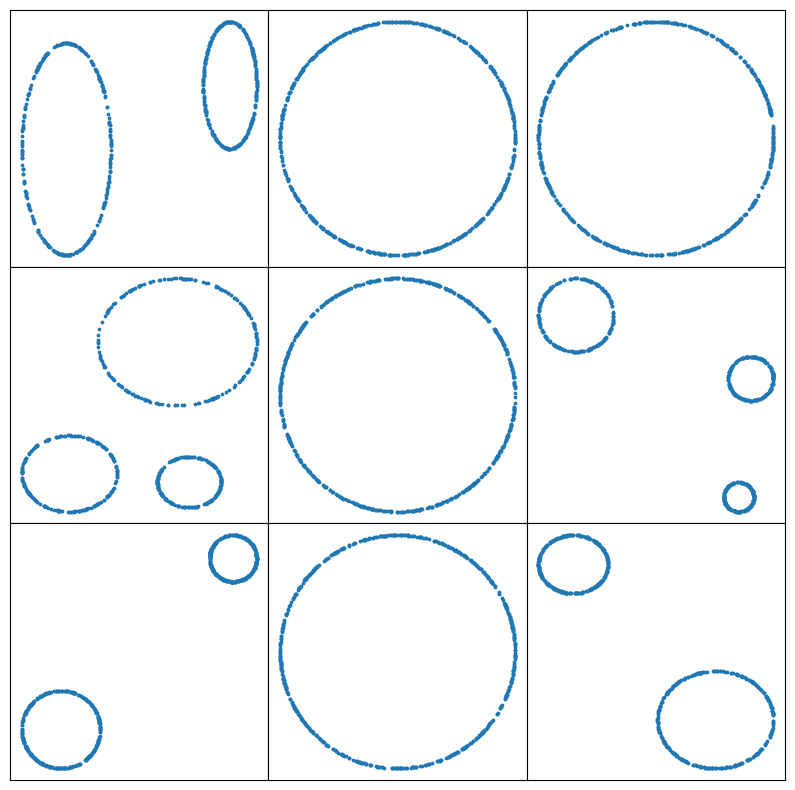

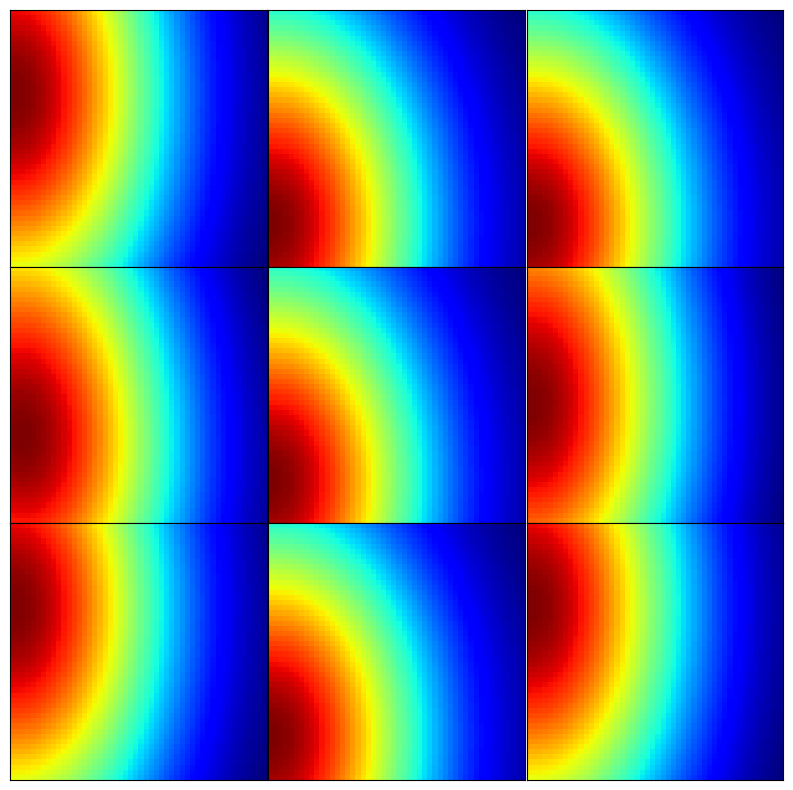

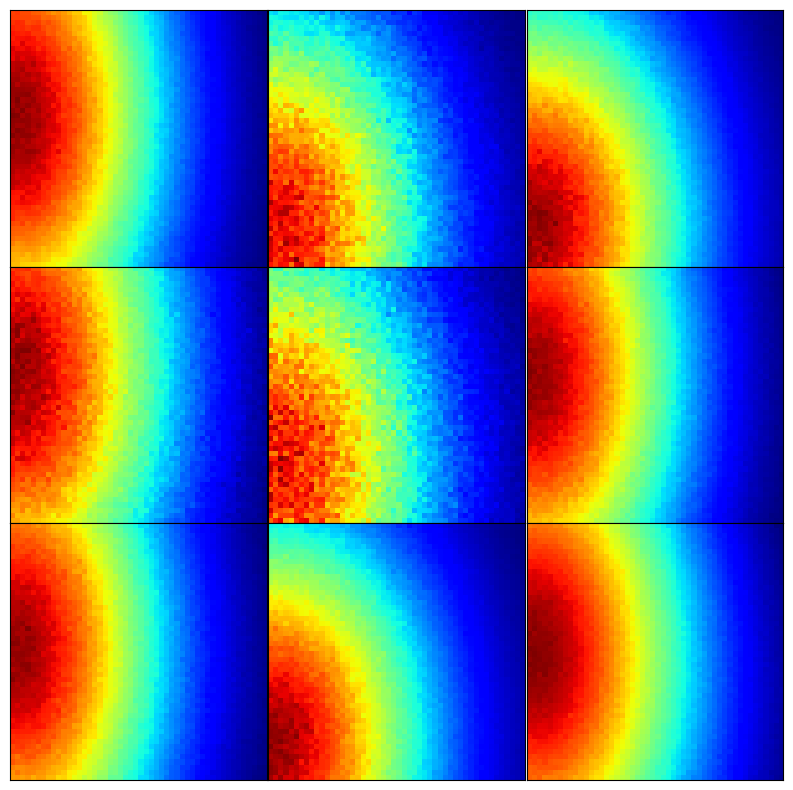

In [39]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_clean_data_test[3*i+j,:,0], tf_clean_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

Pretty good actually! Let's look at the test set now.

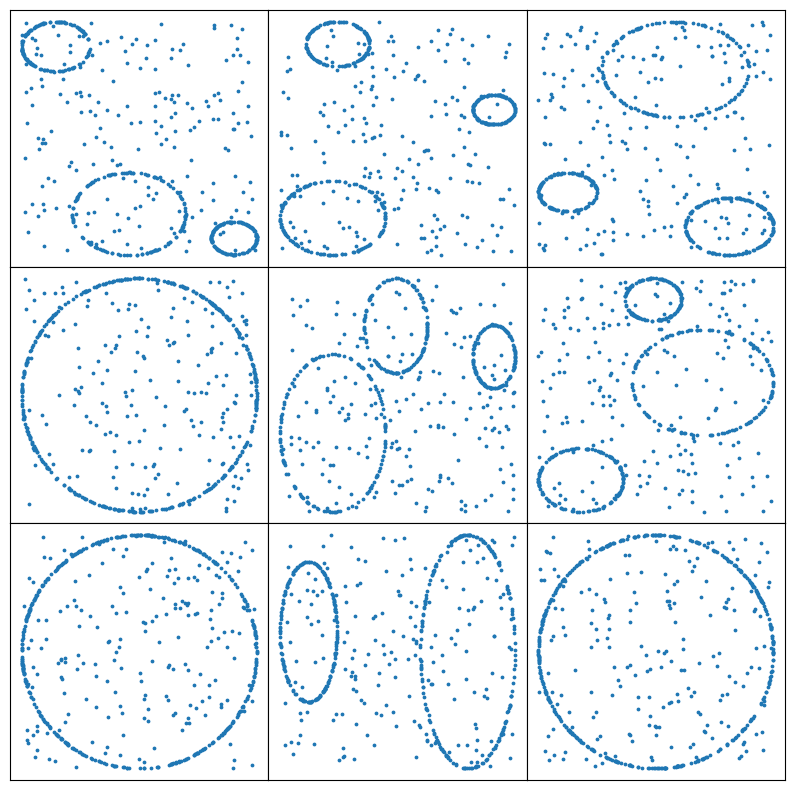

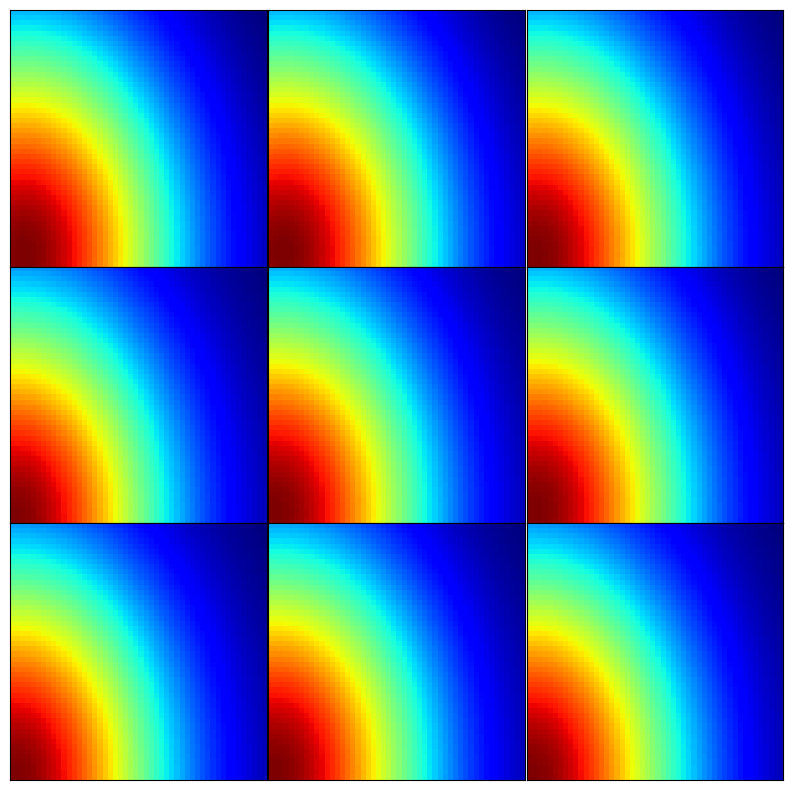

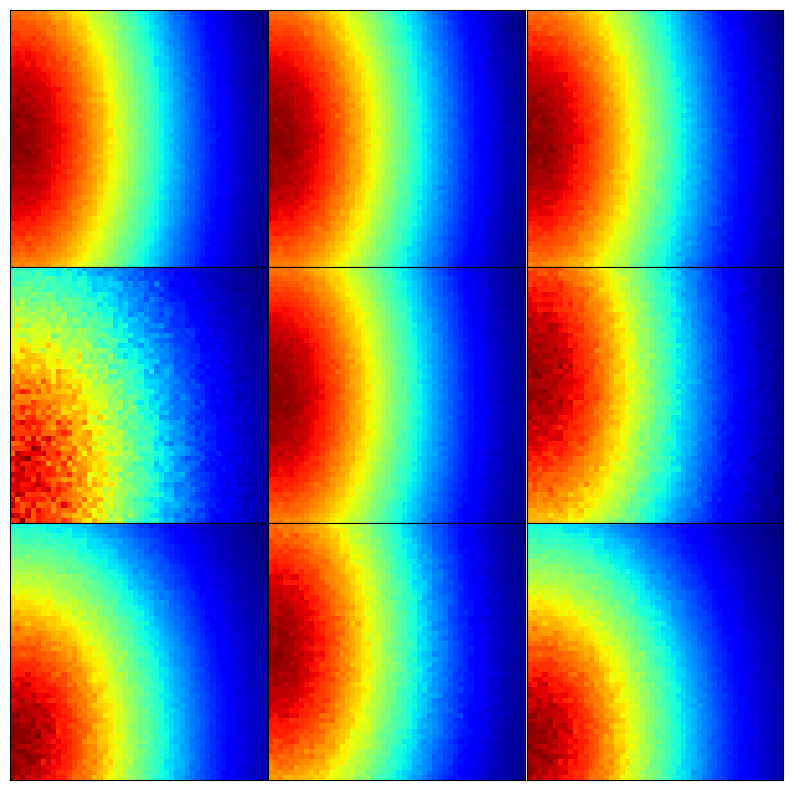

In [48]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_noisy_data_test[3*i+j,:,0], tf_noisy_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(noisy_PI_test[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])


fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(noisy_PI_prediction[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()

Yep, even though Gudhi now produces bad images because of the ambiant noise, RipsNet predictions still look rather good. Another way to quantify this is to see the difference between classifiers predicting the number of circles that are trained either from Gudhi or from RipsNet predictions. Let's first see how an XGBoost model performs when using Gudhi descriptors.

In [41]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)

In [42]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 0.9966666666666667
Accuracy on noisy test set = 0.3333333333333333


Well, the classifier definitely does well on clean data but struggles on noisy data. Let's see how another classifier trained on RipsNet descriptors now performs.

In [43]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)

In [44]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.7333333333333333
Accuracy on noisy test set = 0.7033333333333334


Well, even though the accuracy is slightly worse on clean data, it does remarkably well when noise is added! This illustrates the robustness of RipsNet-based topological descriptors.

Now, let's play the same game with persistence landscapes, using the same architecture (except for the dimension of the final layer of course). In the three following cells, we define RipsNet, train it on landscapes, and use it to predict persistence landscapes from the data.

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=200, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)
x = tf.keras.layers.Dense(50,  activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
outputs = tf.keras.layers.Dense(PL_train.shape[1], activation='sigmoid')(x)
model_PL = tf.keras.Model(inputs=inputs, outputs=outputs)
model_PL.compile(optimizer=optim, loss="mse")

(2, 30)
(30, 20)
(20, 10)
(None, 10)


In [46]:
history = model_PL.fit(tf_data_train, PL_train, epochs=1000, 
                       validation_data=(tf_clean_data_test, clean_PL_test), callbacks=[callback], verbose=0)

(None, 10)
(None, 10)
(None, 10)


In [47]:
train_PL_prediction = model_PL.predict(tf_data_train)
clean_PL_prediction = model_PL.predict(tf_clean_data_test)
noisy_PL_prediction = model_PL.predict(tf_noisy_data_test)

(None, 10)
10/10 [==============================] - 0s 6ms/step


Let's see how good RipsNet is for landscapes now.

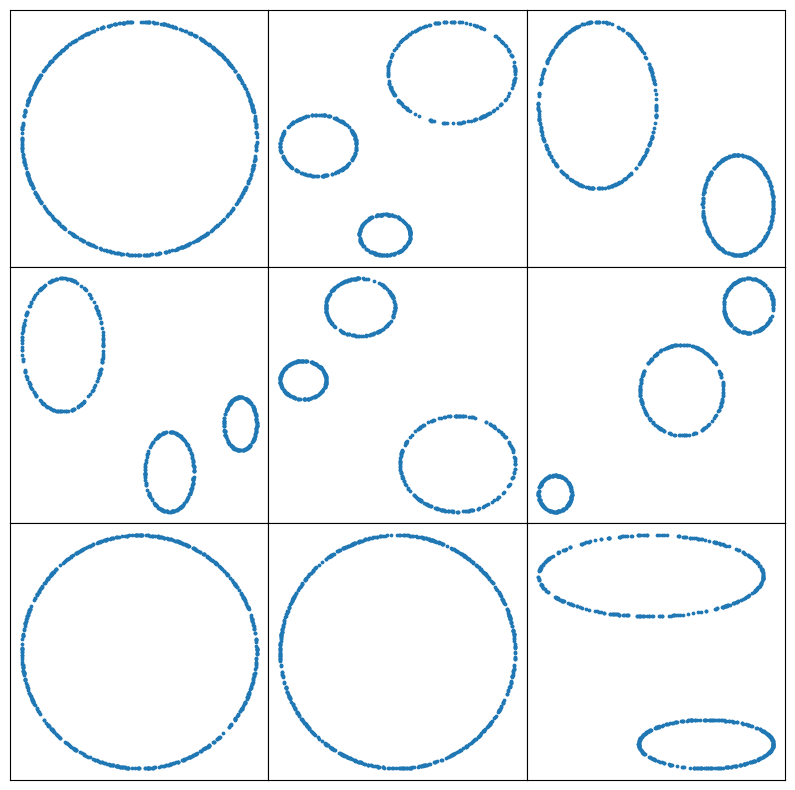

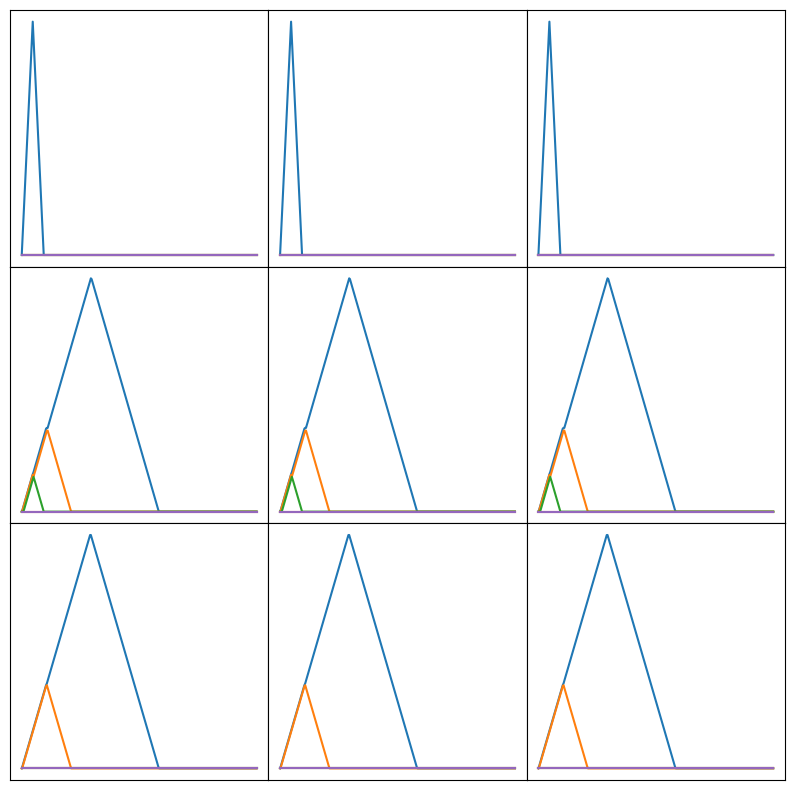

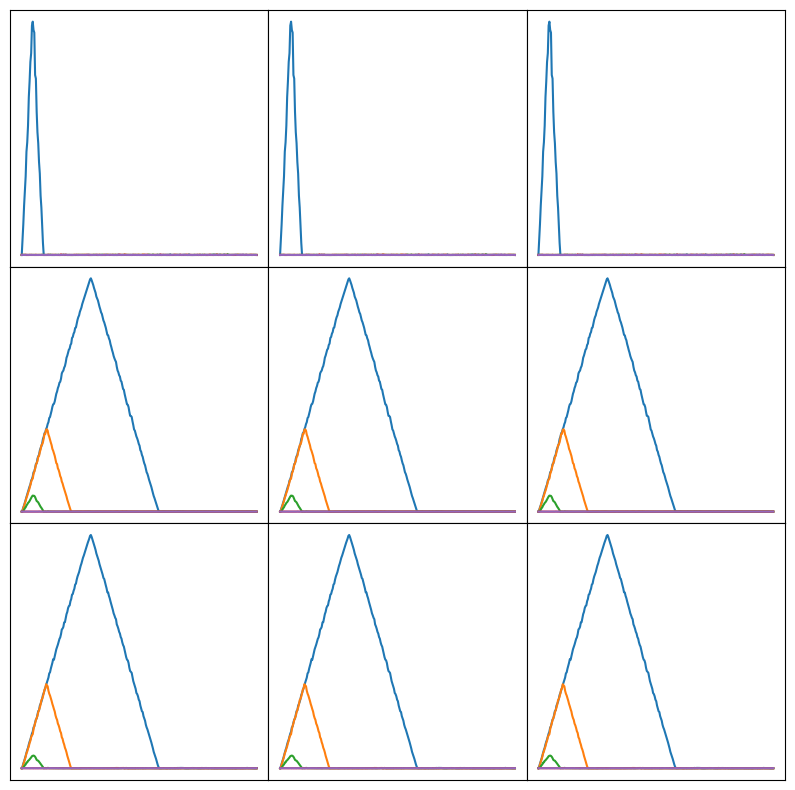

In [28]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_clean_data_test[3*i+j,:,0], tf_clean_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(clean_PL_test[i][lidx*300:(lidx+1)*300]) 
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pl.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(clean_PL_prediction[i][lidx*300:(lidx+1)*300])
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_ripsnet_pl.png', bbox_inches='tight')

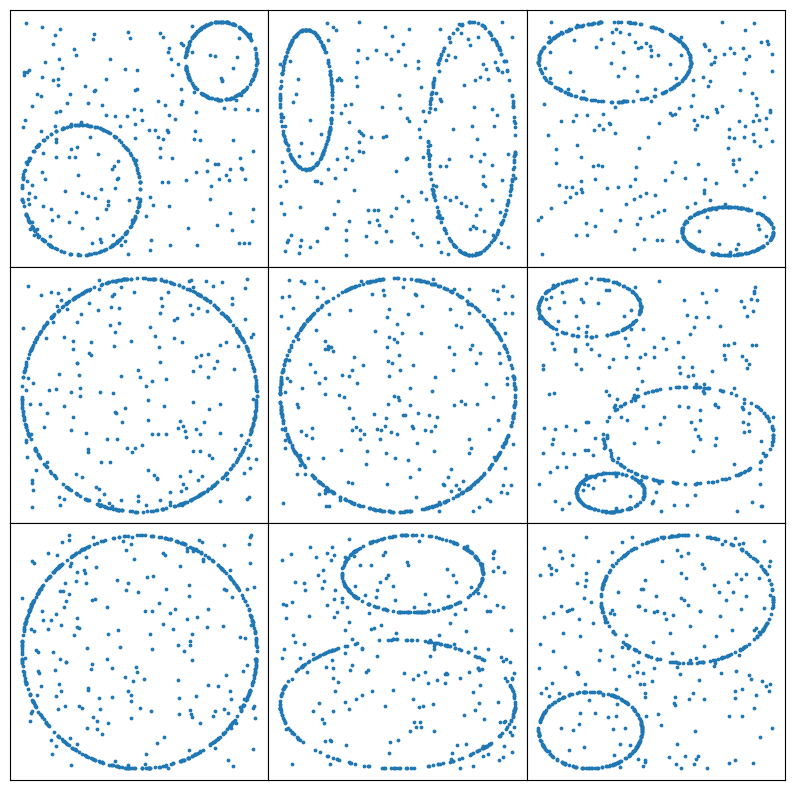

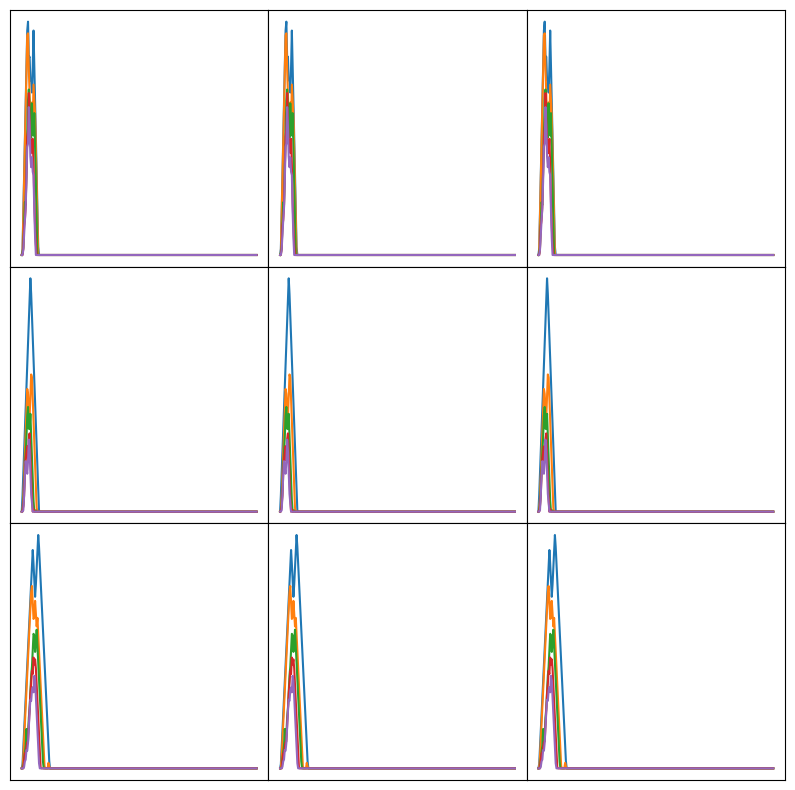

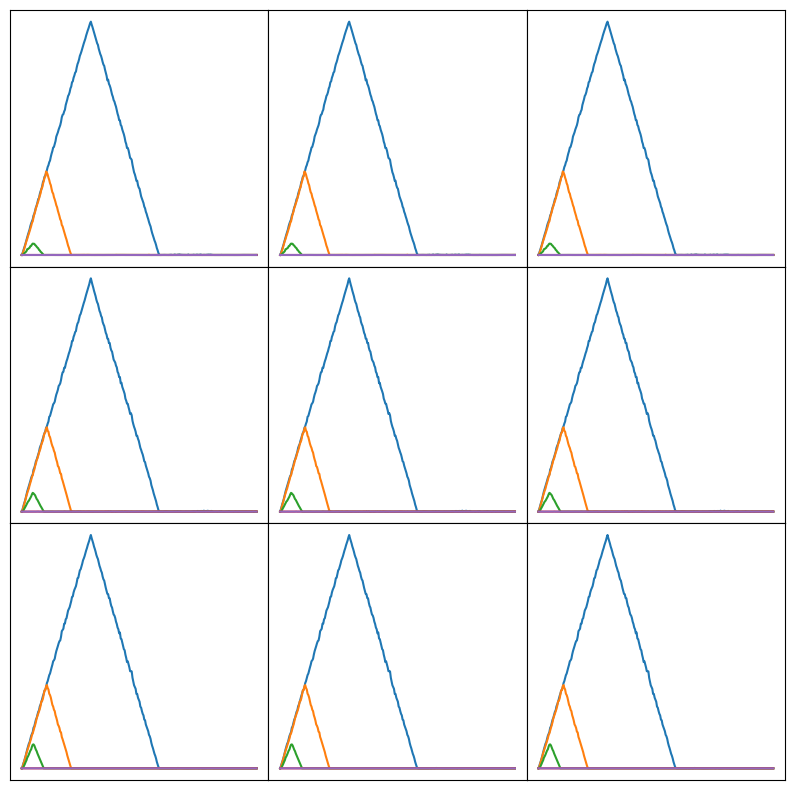

In [29]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_noisy_data_test[3*i+j,:,0], tf_noisy_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(noisy_PL_test[i][lidx*300:(lidx+1)*300]) 
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pl.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(noisy_PL_prediction[i][lidx*300:(lidx+1)*300])
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_ripsnet_pl.png', bbox_inches='tight')

As before, we end by training XGBoost classifier on both Gudhi and RipsNet generated landscapes.

In [30]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PL_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PL_test,  clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PL_test,  noisy_label_classif_test)

In [31]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 0.9966666666666667
Accuracy on noisy test set = 0.6666666666666666


In [32]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)

In [33]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.6966666666666667
Accuracy on noisy test set = 0.7033333333333334


The difference is less clear than for persistence images, but present nonetheless! Again, RipsNet exhibits better  robustness properties than Gudhi on noise data, while being faster and almost as good on clean data.